In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# test on mesa standardized data

mesa_raw = pd.read_csv('../data_processed/MESA/Y_BaselineX_std_full.csv', index_col=False)
mesa_raw = mesa_raw.dropna()

analysis_feature = ['Y_10y','nSES','nFavFood','nPhysFac', 'nRS', 
                    'FamIncome', 'nutrition', 'PhysAct', 'currentSmoker', 'alc',
                    'age', 'race','gender', 'Diabetes', 'hdl', 'totchol', 'sbp']

mesa_raw = mesa_raw[analysis_feature]

data = mesa_raw.copy()

data.head()

,Y_10y,nSES,nFavFood,nPhysFac,nRS,FamIncome,nutrition,PhysAct,currentSmoker,alc,age,race,gender,Diabetes,hdl,totchol,sbp
2,0,0.839784,-0.567637,-0.617829,1.124133,2.0,0.0,2.0,1.0,0.0,78.0,3.0,0.0,0.0,-0.874730,0.107220,1.065434
3,0,0.609360,-0.387280,-0.523760,-0.027422,3.0,0.0,2.0,0.0,0.0,60.0,3.0,1.0,1.0,-1.009534,-0.424293,0.693228
4,0,-0.826608,-0.387280,-0.335622,-0.859692,2.0,0.0,1.0,1.0,0.0,70.0,3.0,0.0,0.0,0.405907,1.170247,0.879331
5,0,-0.120892,-0.657816,-0.570794,-0.722666,3.0,1.0,2.0,0.0,0.0,62.0,3.0,0.0,0.0,-0.065907,-0.564165,1.763318
8,0,0.910067,-0.477459,-0.523760,1.922310,2.0,1.0,1.0,1.0,0.0,53.0,3.0,0.0,0.0,0.540711,0.582785,0.297760


In [ ]:
data['nSES'].plot.kde()

plt.title('Density Plot for nSES')
plt.xlabel('nSES Values')
plt.ylabel('Density')

# Display the plot
plt.show()

In [3]:
# Step 1: estimate propensity density

def conditional_densities(data, use_confounders=True):
    formula = "nSES ~ 1" 
    if use_confounders:
        formula += """ + 
        nFavFood + nPhysFac + nRS+
        FamIncome+C(nutrition)+C(PhysAct)+C(currentSmoker)+C(alc)+
        age + sbp + hdl + totchol + C(Diabetes) + C(race)
        """
    model = sm.formula.ols(formula, data=data).fit()
    density = stats.norm( 
        loc=model.fittedvalues,
        scale=model.resid.std(),
    )  # a series of distributions?
    densities = density.pdf(data["nSES"])
    densities = pd.Series(densities, index=model.fittedvalues.index)
    return densities

denominator = conditional_densities(data, use_confounders=True)
numerator = conditional_densities(data, use_confounders=False)
# weight
generalized_ipw = numerator / denominator


In [4]:
# Step 2: Weighted Logistic regression 

# msm = sm.formula.wls(  
#     "Y_10y ~ 1 + nSES + I(nSES**2) + I(nSES**3)",
#     data=data,
#     weights=generalized_ipw,
# ).fit()

model = smf.logit(formula='Y_10y ~ 1 + nSES', data=data, weights=generalized_ipw).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.302876
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Y_10y   No. Observations:                 4619
Model:                          Logit   Df Residuals:                     4617
Method:                           MLE   Df Model:                            1
Date:                Sat, 17 Feb 2024   Pseudo R-squ.:                0.002659
Time:                        21:31:47   Log-Likelihood:                -1399.0
converged:                       True   LL-Null:                       -1402.7
Covariance Type:            nonrobust   LLR p-value:                  0.006305
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3047      0.051    -44.869      0.000      -2.405      -2.204
nSES           0.1388      0.

/Users/cxt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
/Users/cxt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


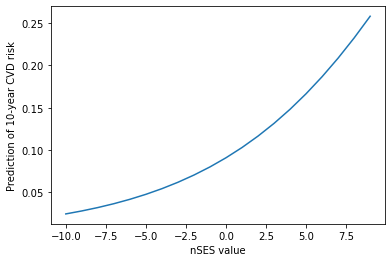

In [5]:
# visualize the predictions

dosage = list(range(-10,10))  # hypothesized dosage value for plotting
dosage = pd.DataFrame(
    data={"nSES": dosage},
    index=dosage,
)
response = model.predict(dosage)
ax = response.plot(
    kind="line",
    xlabel="nSES value",
    ylabel="Prediction of 10-year CVD risk"
)


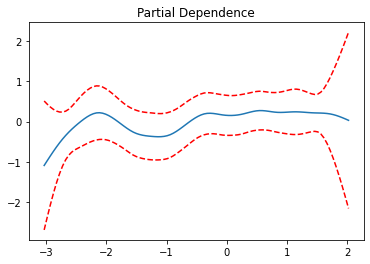

In [8]:
# check logistic regression assumption 

import pygam
from pygam import LogisticGAM, s

X = data['nSES']  # Predictor variables
y = data['Y_10y']  # Response variable

# Fit a GAM with a spline for each predictor variable
gam = LogisticGAM(s(0)).fit(X, y)

# Plot the partial dependence for each predictor to inspect linearity
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    plt.figure()
    plt.plot(XX[:, i], pdep)
    plt.plot(XX[:, i], confi, c='r', ls='--')
    plt.title(f'Partial Dependence')
    plt.show()

## roughly linear, assumption holds